## 1. Importing Libraries & Load the file

https://github.com/shivamsingh96/Facial-Expression-Detection-using-CNN-Real-Time-Recognition-with-Webcam/blob/main/Real-Time%20Facial%20Expression%20Detection%20%26%20Recognition%20using%20CNN.ipynb

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [10]:
# Reading Dataset
data = pd.read_csv("data/train.csv")
data.head(10)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,255 254 255 254 254 179 122 107 95 124 149 150...


In [11]:
# Checking Shape of data
data.shape

(28709, 2)

## 2. Data Visualization

In [12]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
label_to_text

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'happiness',
 4: 'sadness',
 5: 'surprise',
 6: 'neutral'}

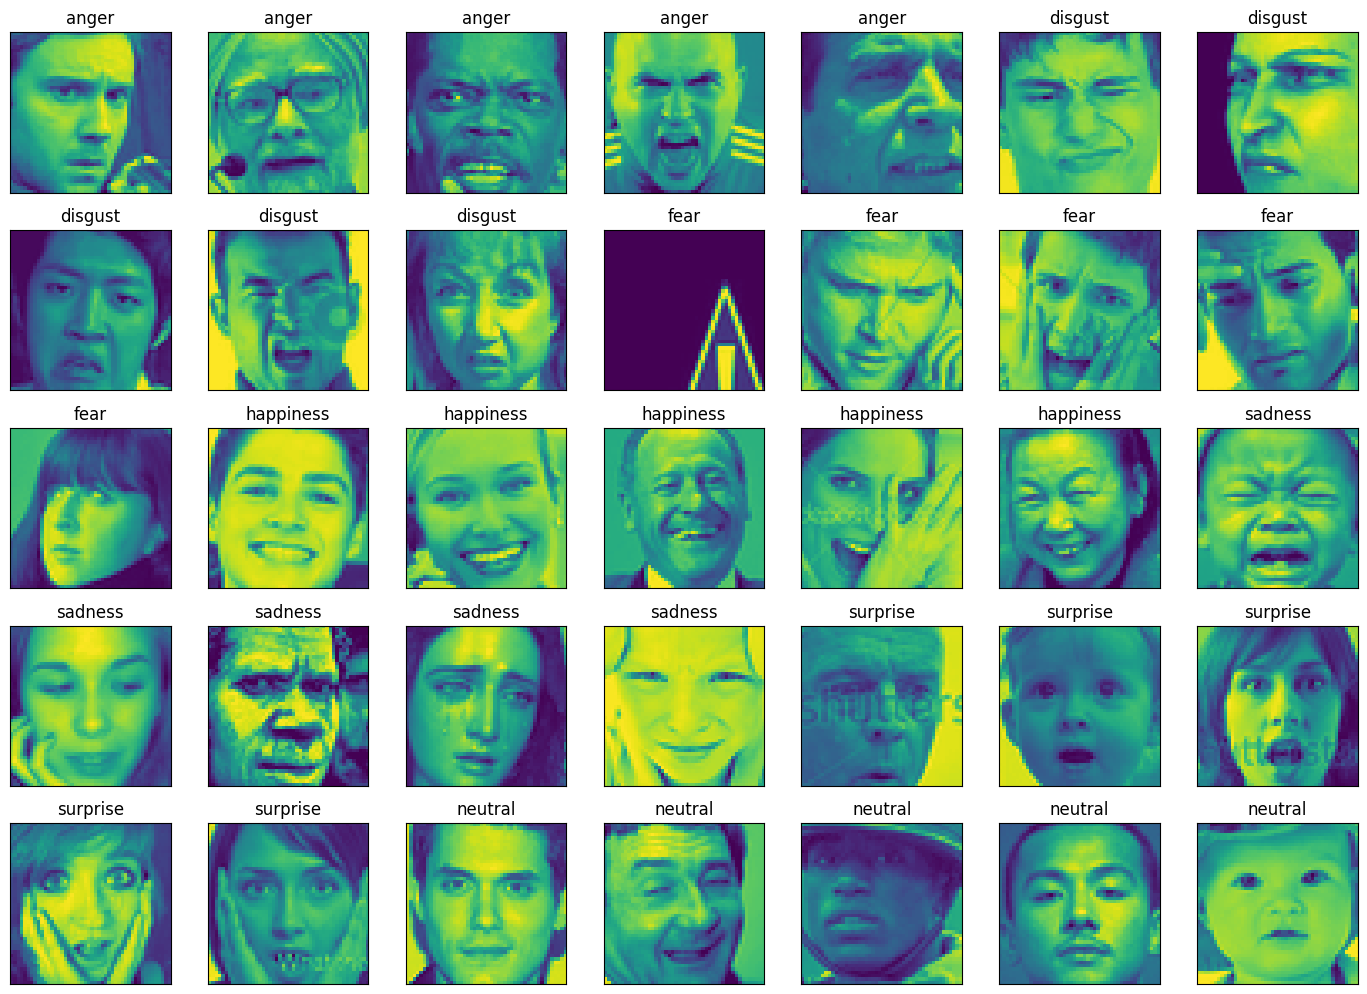

In [13]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

In [14]:
# Checking Emotion Class Distribution
data['emotion'].value_counts()

emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64

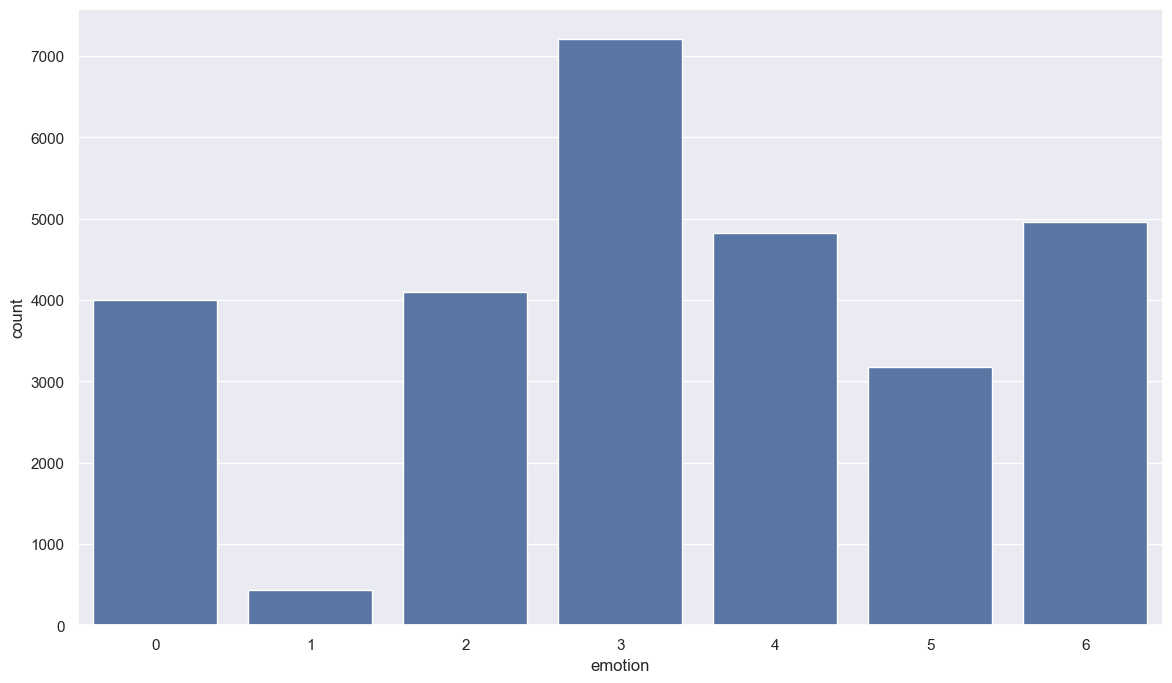

In [15]:
# Plotting the above distribution
plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

*From the above chart, we can observe that the data is highly imbalnace and for some emotions we have very small number of images, so we need to balnce the data by oversampling technique, so to that enough number of images for every emotions(class).*

## 3. Data Pre-processing (Balancing & Preparation)

In [16]:
# Split the data into feature & target variable
x_data = data['pixels']
y_data = data['emotion']

In [17]:
# Perform Random Over Sampling to balance the data
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(50505, 1)   (50505,)


In [18]:
# Let's check the distributio of target data again after balancing
y_data.value_counts()

emotion
0    7215
2    7215
4    7215
6    7215
3    7215
5    7215
1    7215
Name: count, dtype: int64

In [19]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
50500    72 66 54 34 27 24 31 30 25 34 41 56 79 112 138...
50501    99 113 113 120 119 126 134 135 135 136 106 108...
50502    20 5 0 5 26 46 80 106 89 94 81 80 77 76 87 103...
50503    29 29 29 26 24 24 28 45 75 84 90 101 113 119 1...
50504    89 94 88 94 95 93 93 89 85 95 88 94 101 99 104...
Length: 50505, dtype: object

In [20]:
# Normalize the data
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [21]:
# Reshaping
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(50505, 48, 48, 1)

In [22]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(50505, 1)

In [23]:
# Split the data and create train-test set
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [24]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((45454, 48, 48, 1), (5051, 48, 48, 1), (45454, 1), (5051, 1))

In [25]:
# Perform One-Hot Encoding on training data
y_train = to_categorical(y_train, 7)
y_train.shape

(45454, 7)

In [26]:
# Perform One-Hot Encoding on test data
y_test = to_categorical(y_test, 7)
y_test.shape

(5051, 7)

## 4. Model Building

In [27]:
model = Sequential([
    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(250, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(7, activation = 'softmax')
])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │       512,250 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 792,855 (3.02 MB)

 Trainable params: 792,023 (3.02 MB)

 Non-trainable params: 832 (3.25 KB)

## 5. Model Training

In [29]:
# Model Flowchart
tf.keras.utils.plot_model(model, to_file = "/content/drive/MyDrive/Thesis Work - Facial Expression Detection & Recognition using Deep Learning/best_model.png", show_shapes = True, show_dtype = True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [30]:
# Compile the Model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the Model
history = model.fit(x_train, y_train, epochs = 35, validation_data=(x_test, y_test))

Epoch 1/35
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 163s 111ms/step - accuracy: 0.2165 - loss: 2.0046 - val_accuracy: 0.3243 - val_loss: 1.7577
Epoch 2/35
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 165s 116ms/step - accuracy: 0.3465 - loss: 1.6771 - val_accuracy: 0.3845 - val_loss: 1.6411
Epoch 3/35
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 162s 114ms/step - accuracy: 0.4295 - loss: 1.4965 - val_accuracy: 0.4609 - val_loss: 1.4339
Epoch 4/35
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 133s 94ms/step - accuracy: 0.4758 - loss: 1.3789 - val_accuracy: 0.5027 - val_loss: 1.3043
Epoch 5/35
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 136s 96ms/step - accuracy: 0.5134 - loss: 1.2803 - val_accuracy: 0.5627 - val_loss: 1.1545
Epoch 6/35
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 138s 97ms/step - accuracy: 0.5489 - loss: 1.1873 - val_accuracy: 0.5694 - val_loss: 1.1094
Epoch 7/35
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 134s 95ms/step - accuracy: 0.5651 - loss: 1.1342 - val_accuracy: 0.6034 - val_loss: 1.0257
Epoch 8/35
1421/1421 ━━━━━━━━━━━━━━━━━━━━ 137s 96ms/step - accurac

## 6. Model Evaluation

In [32]:
print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")
print("Loss of our model on test data : " , model.evaluate(x_test, y_test)[0])

158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8307 - loss: 0.5356
Accuracy of our model on test data :  82.43911862373352 %
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8307 - loss: 0.5356
Loss of our model on test data :  0.5656759738922119


***The test accuracy & loss of our model is 81.31% & 0.605 respectively, which is better than many exsited state-of-the-art results.***

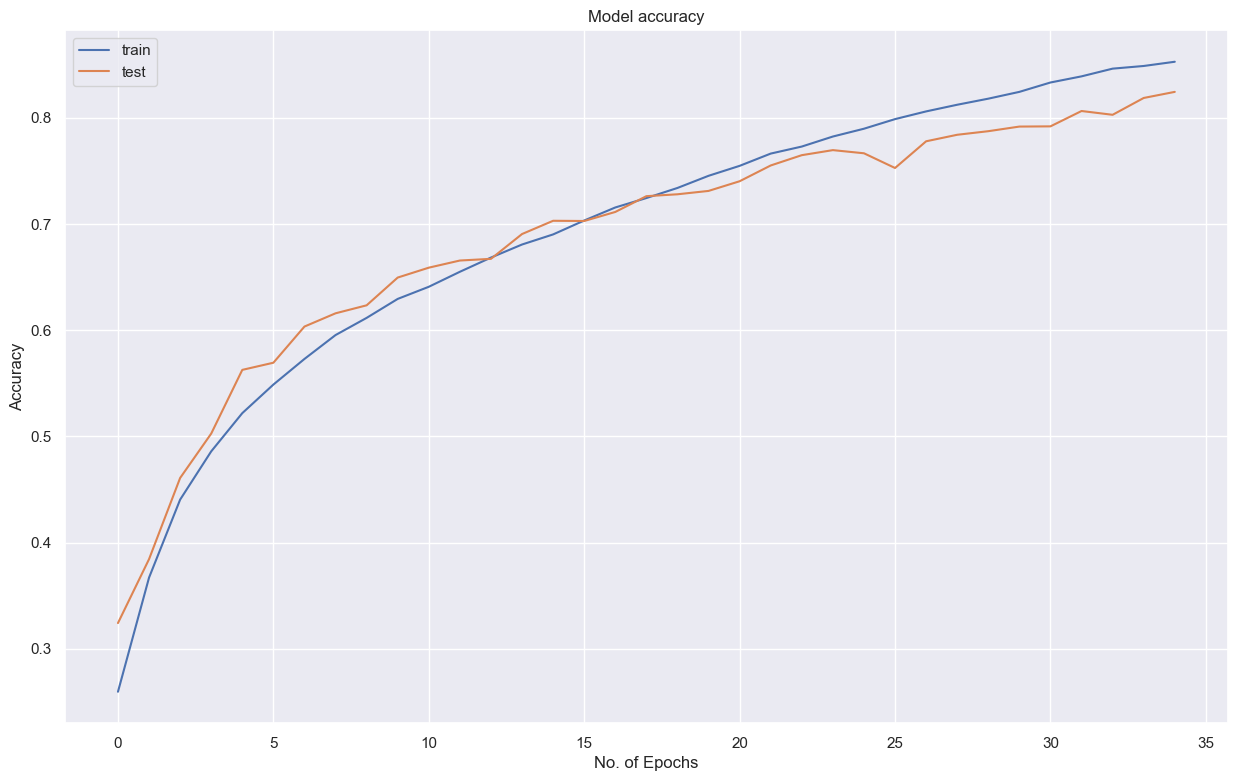

In [33]:
plt.figure(figsize=(15, 9))

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

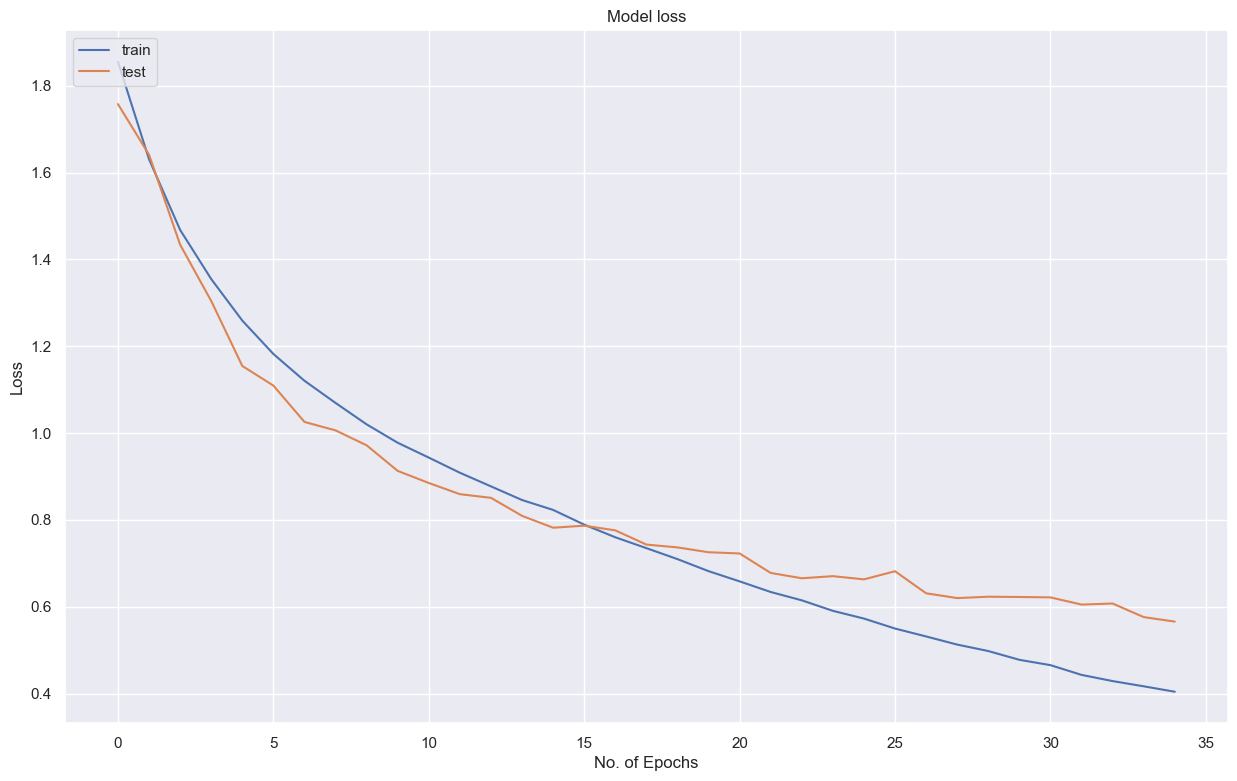

In [34]:
plt.figure(figsize=(15, 9))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 7. Getting Classification Report & Plotting Confusion Matrix

In [35]:
# Making Predictio on Test Data
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


[0, 0, 0, 2, 5, 4, 2, 4, 4, 3]

In [36]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[0, 0, 0, 2, 5, 2, 2, 2, 2, 6]

In [37]:
# Getting Classification Report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       692
           1       0.99      1.00      1.00       698
           2       0.75      0.77      0.76       735
           3       0.84      0.83      0.83       756
           4       0.67      0.74      0.70       711
           5       0.93      0.94      0.93       753
           6       0.78      0.69      0.73       706

    accuracy                           0.82      5051
   macro avg       0.83      0.82      0.82      5051
weighted avg       0.83      0.82      0.82      5051



Text(179.75, 0.5, 'Truth')

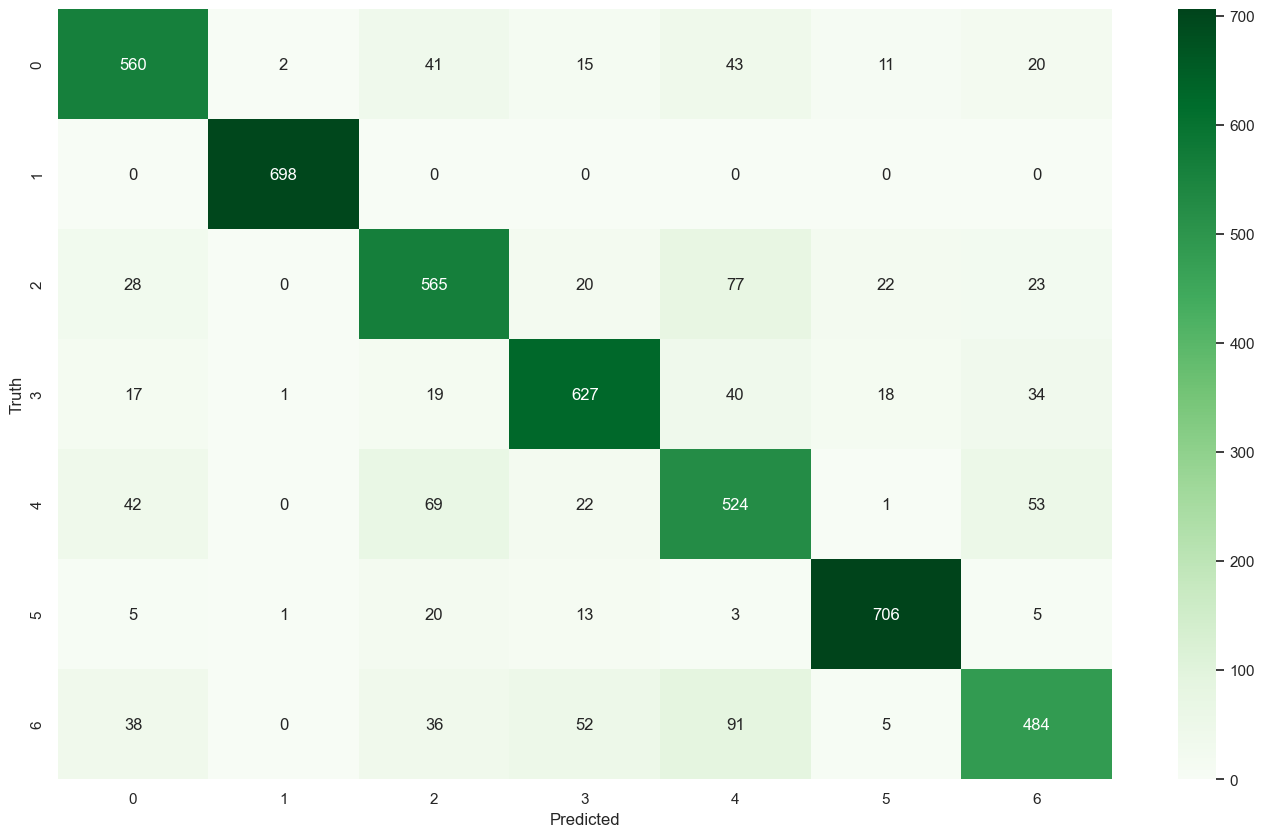

In [38]:
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (17, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('Truth')